<a href="https://colab.research.google.com/github/20rish/Text-Summarizer-Project/blob/main/aiplanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-12-1490802719.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = df['age_group'].map({'Adult': 0, 'Senior': 1})



Class Distribution:
age_group
0    1638
1     314
Name: count, dtype: int64


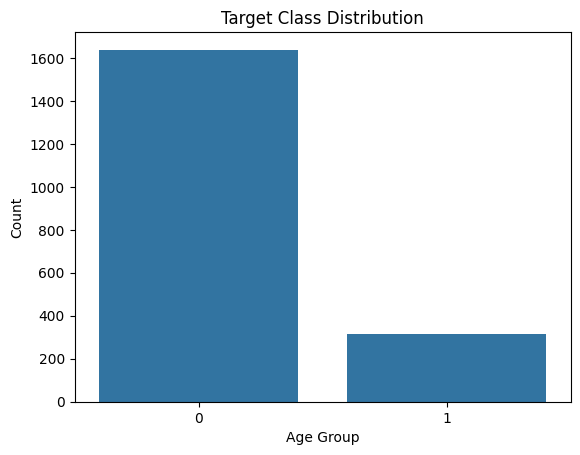

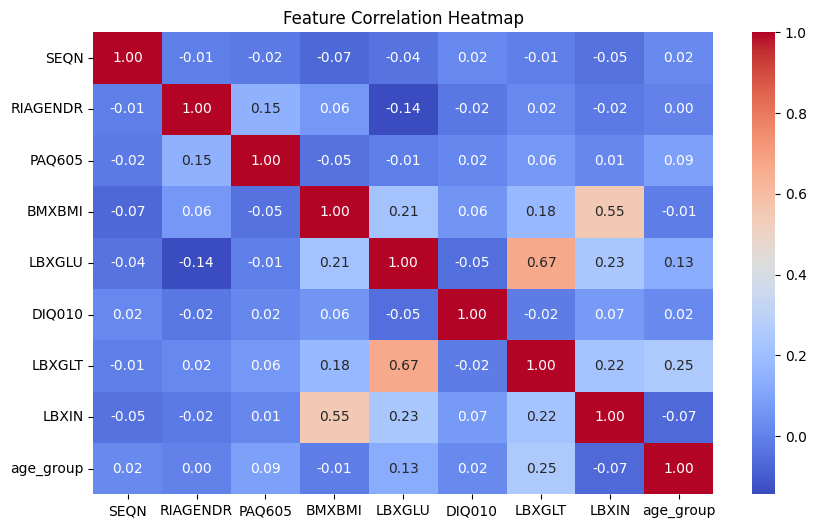

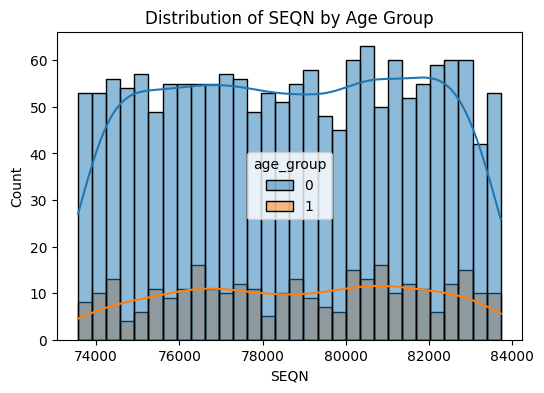

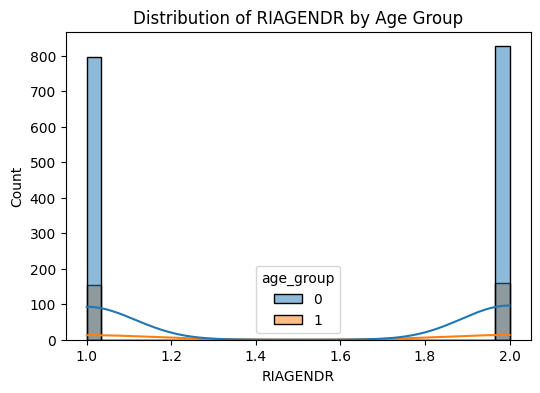

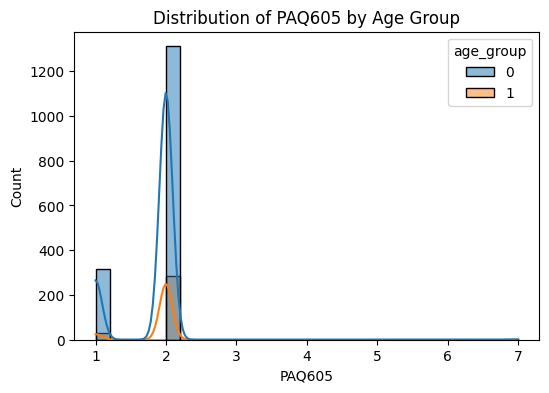

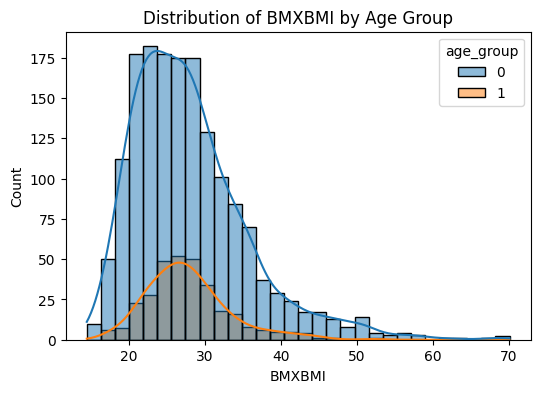

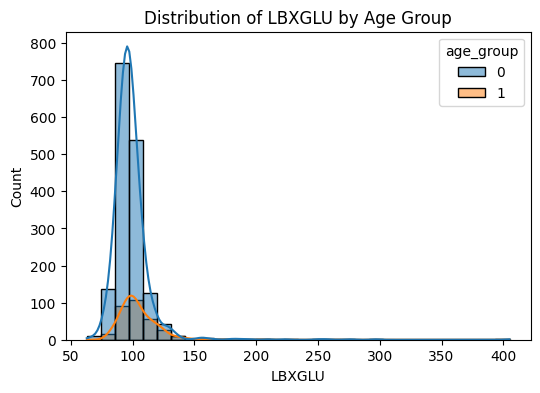

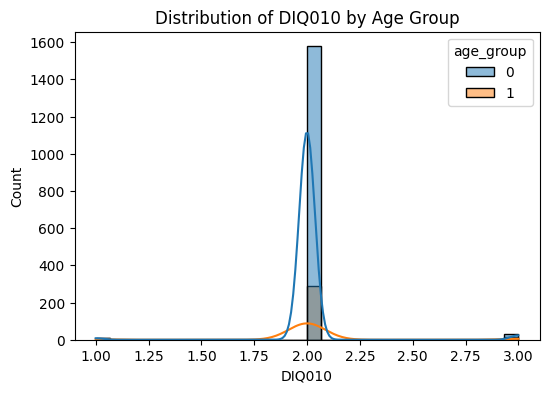

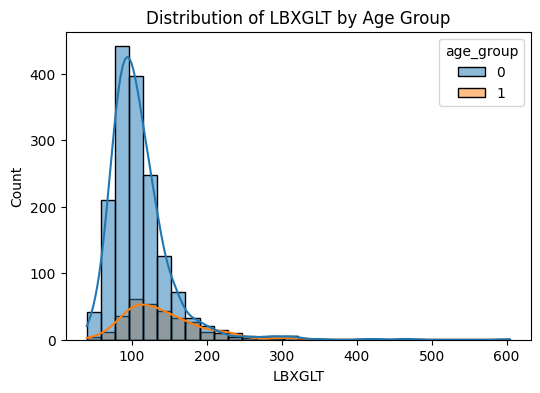

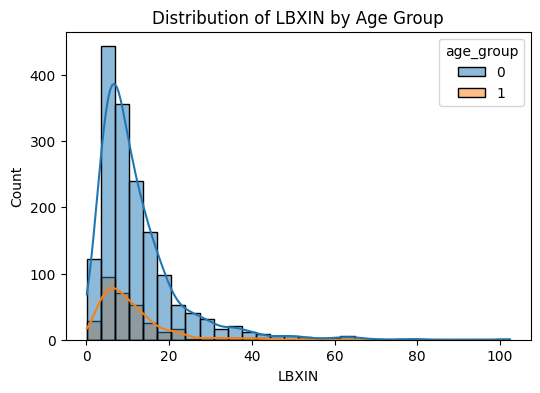


Classification Report (XGBoost):

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       328
           1       0.26      0.14      0.19        63

    accuracy                           0.80       391
   macro avg       0.56      0.53      0.54       391
weighted avg       0.75      0.80      0.77       391


Confusion Matrix (XGBoost):

[[303  25]
 [ 54   9]]

Sample submission:

   age_group
0          0
1          0
2          0
3          0
4          0


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
# Data Analytics Hackathon Notebook

# -----------------------------
# Step 1: Imports & Load Data
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Load train and test CSVs
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")

# -----------------------------
# Step 2: Initial Preprocessing
# -----------------------------

# Drop rows in train with missing target
df = train_df.dropna(subset=['age_group'])

# Encode target
df['age_group'] = df['age_group'].map({'Adult': 0, 'Senior': 1})

# Add dummy target to test for consistent processing
test_df['age_group'] = np.nan

# Combine datasets
combined = pd.concat([df, test_df], ignore_index=True)

# Impute missing numeric values
imputer = SimpleImputer(strategy='median')
numeric_cols = ['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN']
combined[numeric_cols] = imputer.fit_transform(combined[numeric_cols])

# -----------------------------
# Step 3: EDA
# -----------------------------

print("\nClass Distribution:")
print(df['age_group'].value_counts())

# Plot target distribution
sns.countplot(x='age_group', data=df)
plt.title("Target Class Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols + ['age_group']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution plots for numerical features
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue='age_group', kde=True, bins=30)
    plt.title(f"Distribution of {col} by Age Group")
    plt.show()

# -----------------------------
# Step 4: Feature Selection & Split
# -----------------------------

df_clean = combined[~combined['age_group'].isna()]
test_clean = combined[combined['age_group'].isna()].drop(columns=['age_group'])

X = df_clean[numeric_cols]
y = df_clean['age_group'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# -----------------------------
# Step 5: Improved Model - XGBoost
# -----------------------------

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_val)
print("\nClassification Report (XGBoost):\n")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix (XGBoost):\n")
print(confusion_matrix(y_val, y_pred))

# -----------------------------
# Step 6: Generate Submission
# -----------------------------

test_preds = xgb_model.predict(test_clean[numeric_cols])
submission = pd.DataFrame({'age_group': test_preds.astype(int)})
submission.to_csv("submission.csv", index=False)

print("\nSample submission:\n")
print(submission.head())
